In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import pickle

from scipy.stats import chi2_contingency
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import f1_score
from kmodes.kmodes import KModes
from matplotlib import pyplot as plt

# Preprocesing an General View of the Data.

This section is devoted to the preprocessing of the data. I also explore general aspects of the features.

In [2]:
#Importing the data
data = pd.read_csv('ds_challenge_2021.csv')
data.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
0,0,F,608.345634,2020-01-21,20,"{'model': 2020, 'device_score': 3, 'os': 'ANDR...",Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False
1,0,F,88.719243,2020-01-15,7,"{'model': 2020, 'device_score': 1, 'os': 'ANDR...",NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False
2,1,F,790.037653,2020-01-17,11,"{'model': 2020, 'device_score': 1, 'os': '.'}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False
3,1,F,767.005387,2020-01-05,11,"{'model': 2020, 'device_score': 3, 'os': 'WEB'}",MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False
4,1,F,254.171053,2020-01-30,10,"{'model': 2020, 'device_score': 3, 'os': '%%'}",NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False


<font size = "3">The feature "dcto" is better understood a fraction of "monto":  </font>

In [3]:
data.loc[:,'dcto'] = data[['dcto','monto']].apply(lambda row:row[0]/row[1] if row[1]!=0 else 0,axis=1)


<font size="3"> Computing basic statistical measures as below we can make some remarks about numerical features. As "min" and "max" shows for the different numerical features, scales are highly different. So, a regularization of this values is required. About the quartiles, "monto", "hora", "linea_tc", "interes_tc" and even "cashback" shows a near-equally distributed values along the quartiles. While "dcto" shows a concentration of data having value zero. This make sense with the intuition, because discounts are not so usual.

Finally, beacause the max in "ID_USER" is lesser than the number of registers, we possibly have many purchases for an individual user.
</font>

In [4]:
data.describe()

,ID_USER,monto,hora,linea_tc,interes_tc,dcto,cashback
count,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000
mean,2003.765412,499.069493,11.987618,62476.811863,48.224875,0.035192,6.261186
std,1144.630736,289.309518,6.642565,21886.892902,9.587256,0.057170,4.458440
min,0.000000,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138
25%,1041.000000,246.521227,6.000000,44000.000000,40.000000,0.000000,2.791740
50%,2006.000000,500.501022,12.000000,62000.000000,48.000000,0.000000,5.636711
75%,2973.500000,749.598192,18.000000,82000.000000,57.000000,0.100000,8.531604
max,3999.000000,999.917764,23.000000,99000.000000,64.000000,0.200000,19.991582


<font size = '3'>I plot the histogram of ID_USERS to confirm the mentioned before.</font>

<AxesSubplot:>

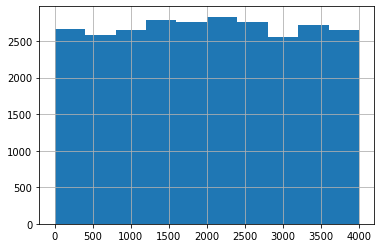

In [5]:
data.ID_USER.hist()

<font size = '3'> I will create a new feature "num_compras" to resgister the number of purchases of a given user.

In [6]:
#Assigning the new column
data['num_compras']=data['ID_USER'].map(data['ID_USER'].value_counts())


<font size="3"> For the assigned classification problem, another important value to consider is the proportion of the categories considered for the classification. In this case we have two categories: fraudsters and non-fraudsters. As shows the next cell, proportion of fraudsters vs non-fraudsters is highly negligible(just 3% of the number of registers). This is a consideration that must be taken in account when the classification algorithm be applied.<font> 

In [7]:
##Proportion of fraudters vs all clients
data.fraude.sum()/len(data.fraude)

0.030027803521779424

<font size = "3">The column "dispositivo" consists of three fields. For itself, this feature is not so descriptive but to consider each field as a feature can help to characterize the clients. So, I extract each field as a new feature in our data.<font>

In [8]:
#Extracting information from column "dispositivo"
#*Each dictionary key is considered as a realization of a categorical variable
nam = list(eval(data.dispositivo.loc[0]).keys())
list_data = (list(data.dispositivo.
                        apply(lambda x:
                        list(map(lambda x:str(x),list(eval(x).values())))
                        )))
data.loc[:,nam] = pd.DataFrame(list_data,columns = nam)


<font size = "3"> In the next cell I identify where there are NaN values.<font>

In [9]:
#Columns with na values
columnas = list(data.columns)
[data[[col]].isna().sum() for col in columnas]

[ID_USER    0
 dtype: int64, genero    0
 dtype: int64, monto    0
 dtype: int64, fecha    0
 dtype: int64, hora    0
 dtype: int64, dispositivo    0
 dtype: int64, establecimiento    10119
 dtype: int64, ciudad    11678
 dtype: int64, tipo_tc    0
 dtype: int64, linea_tc    0
 dtype: int64, interes_tc    0
 dtype: int64, status_txn    0
 dtype: int64, is_prime    0
 dtype: int64, dcto    0
 dtype: int64, cashback    0
 dtype: int64, fraude    0
 dtype: int64, num_compras    0
 dtype: int64, model    0
 dtype: int64, device_score    0
 dtype: int64, os    0
 dtype: int64]

<font size = "3"> The NaN values come from categorical features "ciudad" and "establecimiento". They have a high frequency (more or less the half of the registers are NaN in this features). This suggests that "ciudad" and "establecimiento" cannot be very informative features. I fill here with a new category: "no_asignado". But later I will remove them based in correlation considerations.<font>

In [10]:
#Filling NaN values
data.establecimiento = data.establecimiento.fillna('no_asignado')
data.ciudad = data.ciudad.fillna('no_asignado')

<font size= "3"> In the next cell the data is re-scaled, as suggested in the discussion about quartiles. All the numerical values are re-scaled to vary on the interval [0,1].<font>

In [11]:
# Re escaling the data
cols_num = ['monto','hora','linea_tc','interes_tc','dcto','cashback','num_compras']
scaler = preprocessing.MinMaxScaler()
data[cols_num] = scaler.fit_transform(data[cols_num])
data.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,num_compras,model,device_score,os
0,0,F,0.608389,2020-01-21,0.863636,"{'model': 2020, 'device_score': 3, 'os': 'ANDR...",Super,Merida,Física,0.621622,0.59375,Aceptada,False,0.5,0.273866,False,0.016393,2020,3,ANDROID
1,0,F,0.088711,2020-01-15,0.272727,"{'model': 2020, 'device_score': 1, 'os': 'ANDR...",no_asignado,Merida,Virtual,0.621622,0.59375,Aceptada,False,0.0,0.088750,False,0.016393,2020,1,ANDROID
2,1,F,0.790099,2020-01-17,0.454545,"{'model': 2020, 'device_score': 1, 'os': '.'}",no_asignado,Guadalajara,Virtual,0.932432,0.75000,En proceso,False,0.0,0.790369,False,0.098361,2020,1,.
3,1,F,0.767064,2020-01-05,0.454545,"{'model': 2020, 'device_score': 3, 'os': 'WEB'}",MPago,Guadalajara,Física,0.932432,0.75000,Aceptada,False,0.0,0.383660,False,0.098361,2020,3,WEB
4,1,F,0.254179,2020-01-30,0.409091,"{'model': 2020, 'device_score': 3, 'os': '%%'}",no_asignado,Guadalajara,Física,0.932432,0.75000,Aceptada,False,0.0,0.127133,False,0.098361,2020,3,%%


<font size = "3"> Finally I must mention that "fecha" will be a feature not used in the analysis. By itself it is not very descriptive. So, it is necessary a treatment similar to the one on "dispositivo". For the sake of simplicity I will avoid it.

# Analysis of Categorical Data

<font size="3"> In this section I make a more detailed analysis of categorical data.

In [12]:
#The categorical columns 
cols_categ = ['genero','establecimiento','ciudad','tipo_tc','status_txn','is_prime','model','device_score'
            ,'os','fraude']
data_categ = data.loc[:,cols_categ].copy()
data_categ.head()


,genero,establecimiento,ciudad,tipo_tc,status_txn,is_prime,model,device_score,os,fraude
0,F,Super,Merida,Física,Aceptada,False,2020,3,ANDROID,False
1,F,no_asignado,Merida,Virtual,Aceptada,False,2020,1,ANDROID,False
2,F,no_asignado,Guadalajara,Virtual,En proceso,False,2020,1,.,False
3,F,MPago,Guadalajara,Física,Aceptada,False,2020,3,WEB,False
4,F,no_asignado,Guadalajara,Física,Aceptada,False,2020,3,%%,False


<font size = '3'> The categories for each categorical feature are shown. They play an important role when some ML algorithms are applied. Because a good initial way to deal with categorical variables is to make dummy variables, more categories implies higher dimension of the data. In this case, the number of categories for each variables is reasonable and the dimension of data remains low even considering the dummy variables.

Because "model" has just one category, this feature can be eliminated.

In [13]:
##Categories for each categorical column
[col+' : '+str(list(data.loc[:,col].factorize()[1])) for col in cols_categ]

["genero : ['F', '--', 'M']",
 "establecimiento : ['Super', 'no_asignado', 'MPago', 'Abarrotes', 'Farmacia', 'Restaurante']",
 "ciudad : ['Merida', 'Guadalajara', 'Toluca', 'Monterrey', 'no_asignado']",
 "tipo_tc : ['Física', 'Virtual']",
 "status_txn : ['Aceptada', 'En proceso', 'Rechazada']",
 'is_prime : [False, True]',
 "model : ['2020']",
 "device_score : ['3', '1', '2', '4', '5']",
 "os : ['ANDROID', '.', 'WEB', '%%']",
 'fraude : [False, True]']

<font size = "3">Now I plot frequency histograms for each feature. This shows that all the features of this group have a dominant category, except "os" and "device_score".

<AxesSubplot:>

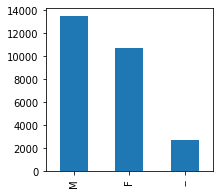

In [14]:

data_categ[cols_categ[0]].value_counts().plot(kind='bar',figsize = [3,3])


<AxesSubplot:>

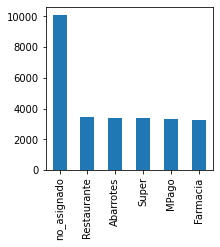

In [15]:
data_categ[cols_categ[1]].value_counts().plot(kind='bar',figsize = [3,3])

<AxesSubplot:>

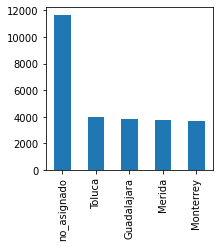

In [16]:
data_categ[cols_categ[2]].value_counts().plot(kind='bar',figsize = [3,3])

<AxesSubplot:>

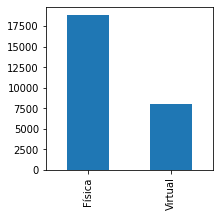

In [17]:
data_categ[cols_categ[3]].value_counts().plot(kind='bar',figsize = [3,3])

<AxesSubplot:>

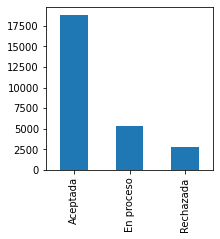

In [18]:
data_categ[cols_categ[4]].value_counts().plot(kind='bar',figsize = [3,3])

<AxesSubplot:>

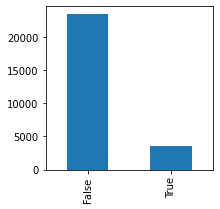

In [19]:
data_categ[cols_categ[5]].value_counts().plot(kind='bar',figsize = [3,3])

<AxesSubplot:>

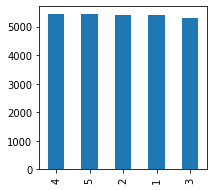

In [20]:
data_categ[cols_categ[7]].value_counts().plot(kind='bar',figsize = [3,3])

<AxesSubplot:>

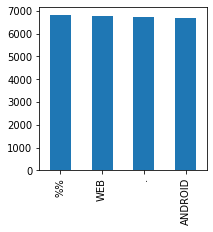

In [21]:
data_categ[cols_categ[8]].value_counts().plot(kind='bar',figsize = [3,3])

<AxesSubplot:>

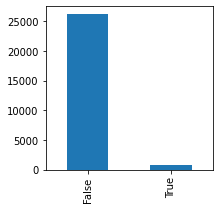

In [22]:
data_categ[cols_categ[9]].value_counts().plot(kind='bar',figsize = [3,3])

<font size = "3">Here the feature "model" is eliminated.

In [23]:
#The feature model is an avoidable column
data_categ = data_categ.drop('model',1)

## Correlation Between Categorical Variables 

<font size = "3">In this subsection I compute the correlation given by the Chi square test on contingency tables in order to determine the correlation between categrical variables.

In [24]:
# Chi square hypothesis test is used to determine correlation 
# between the categorical variables
alpha = 0.05
cols_categ = data_categ.columns
len_c = len(data_categ.columns)
p_vals = np.zeros((len_c,len_c))
for c1 in range(len_c):
    for c2 in range(len_c):
        cont_tab = (pd.crosstab(data_categ[cols_categ[c1]], 
                        columns= data_categ[cols_categ[c2]]))
        p_vals[c1][c2] = 1-chi2_contingency(cont_tab)[1]

df = pd.DataFrame(p_vals,index = cols_categ,columns=cols_categ)
df


,genero,establecimiento,ciudad,tipo_tc,status_txn,is_prime,device_score,os,fraude
genero,1.000000,0.259920,1.000000,0.116132,0.582848,0.999668,0.078845,0.365793,0.578789
establecimiento,0.259920,1.000000,0.648079,0.995042,0.629338,0.786314,0.239518,0.341303,0.174669
ciudad,1.000000,0.648079,1.000000,0.485450,0.186711,0.990788,0.968106,0.096145,0.223573
tipo_tc,0.116132,0.995042,0.485450,1.000000,0.278685,0.556289,0.175583,0.028814,0.603555
status_txn,0.582848,0.629338,0.186711,0.278685,1.000000,0.932558,0.409049,0.421429,0.205128
is_prime,0.999668,0.786314,0.990788,0.556289,0.932558,1.000000,0.162579,0.462393,0.498040
device_score,0.078845,0.239518,0.968106,0.175583,0.409049,0.162579,1.000000,0.180411,0.611782
os,0.365793,0.341303,0.096145,0.028814,0.421429,0.462393,0.180411,1.000000,0.616873
fraude,0.578789,0.174669,0.223573,0.603555,0.205128,0.498040,0.611782,0.616873,1.000000


<font size = "3"> As can be seen, "genero" has a high correlation with "is_prime" and "ciudad". So, I will eliminate "genero", which is explained for "is_prime".

For its part, "tipo_tc" and "establecimiento" are highly correlated. Because "ciudad" and "establecimiento" are not completely informative variables (as discused in the first section) and are highly correlated with another features. This justifies elimination of these two variables. 

Here a visual representation of the correlations:

<AxesSubplot:>

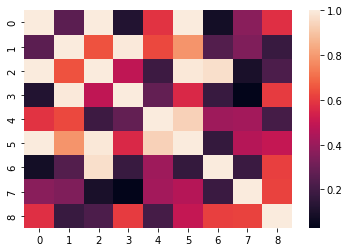

In [25]:
sns.heatmap(p_vals)

In [26]:
#establecimiento, ciudad and genero can be eliminated
data_categ = data_categ.drop('establecimiento',1)
data_categ = data_categ.drop('ciudad',1)
data_categ = data_categ.drop('genero',1)

## Analysis of Numerical Data

<font size = "3">This section explores the numerical features. Here  "num_compras" is considered as numerical feature and allows me to avoid "ID_USER", because the new feature contains the important information of each user. 

In [27]:
#The numerical columns
cols_num = ['monto','hora','linea_tc','interes_tc','dcto','cashback','num_compras','fraude']
data_num = data.loc[:,cols_num]
data_num.head()

,monto,hora,linea_tc,interes_tc,dcto,cashback,num_compras,fraude
0,0.608389,0.863636,0.621622,0.59375,0.5,0.273866,0.016393,False
1,0.088711,0.272727,0.621622,0.59375,0.0,0.088750,0.016393,False
2,0.790099,0.454545,0.932432,0.75000,0.0,0.790369,0.098361,False
3,0.767064,0.454545,0.932432,0.75000,0.0,0.383660,0.098361,False
4,0.254179,0.409091,0.932432,0.75000,0.0,0.127133,0.098361,False


<font size = "3">To determine the linear correlation between the features the Pearson correlation is computed:

In [28]:
# Pearson correlation
corr_num = data_num.corr(method = 'pearson')
corr_num

,monto,hora,linea_tc,interes_tc,dcto,cashback,num_compras,fraude
monto,1.000000,-0.004348,-0.008415,0.014449,-0.005867,0.814530,0.002589,-0.004239
hora,-0.004348,1.000000,0.003117,0.000413,0.007854,-0.009657,-0.002765,0.013376
linea_tc,-0.008415,0.003117,1.000000,-0.039932,0.005729,-0.003100,0.000044,-0.000488
interes_tc,0.014449,0.000413,-0.039932,1.000000,0.002849,0.012961,0.030991,-0.003130
dcto,-0.005867,0.007854,0.005729,0.002849,1.000000,-0.084715,0.002966,-0.001160
cashback,0.814530,-0.009657,-0.003100,0.012961,-0.084715,1.000000,0.003788,-0.004337
num_compras,0.002589,-0.002765,0.000044,0.030991,0.002966,0.003788,1.000000,0.001090
fraude,-0.004239,0.013376,-0.000488,-0.003130,-0.001160,-0.004337,0.001090,1.000000


<font size = "3">In this case just "monto" and "cashback" have a strong correlation. I will keep "monto" and aliminate "cashback". The rest of the features has little and almost always positive Pearson's correlation. In particular, no relevant correlation with "fraude" (the feature to be predicted) exists for any of the another numerical features.

A visual representation of correlations appears below:

<AxesSubplot:>

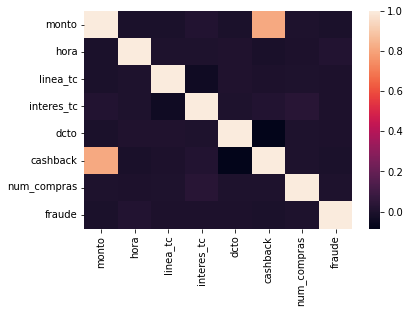

In [29]:
sns.heatmap(corr_num)

In [30]:
#Because the high correlation between monto and cashback, I will avoid cashback
data_num = data_num.drop('cashback',1)

<font size="3"> In order to determine if there exists a non linear correlation between this group of variables, the scatter plots F_i vs F_j are considered, where F_i,F_j are features in this group.

array([[<AxesSubplot:xlabel='monto', ylabel='monto'>,
        <AxesSubplot:xlabel='hora', ylabel='monto'>,
        <AxesSubplot:xlabel='linea_tc', ylabel='monto'>,
        <AxesSubplot:xlabel='interes_tc', ylabel='monto'>,
        <AxesSubplot:xlabel='dcto', ylabel='monto'>,
        <AxesSubplot:xlabel='num_compras', ylabel='monto'>,
        <AxesSubplot:xlabel='fraude', ylabel='monto'>],
       [<AxesSubplot:xlabel='monto', ylabel='hora'>,
        <AxesSubplot:xlabel='hora', ylabel='hora'>,
        <AxesSubplot:xlabel='linea_tc', ylabel='hora'>,
        <AxesSubplot:xlabel='interes_tc', ylabel='hora'>,
        <AxesSubplot:xlabel='dcto', ylabel='hora'>,
        <AxesSubplot:xlabel='num_compras', ylabel='hora'>,
        <AxesSubplot:xlabel='fraude', ylabel='hora'>],
       [<AxesSubplot:xlabel='monto', ylabel='linea_tc'>,
        <AxesSubplot:xlabel='hora', ylabel='linea_tc'>,
        <AxesSubplot:xlabel='linea_tc', ylabel='linea_tc'>,
        <AxesSubplot:xlabel='interes_tc', ylabel='

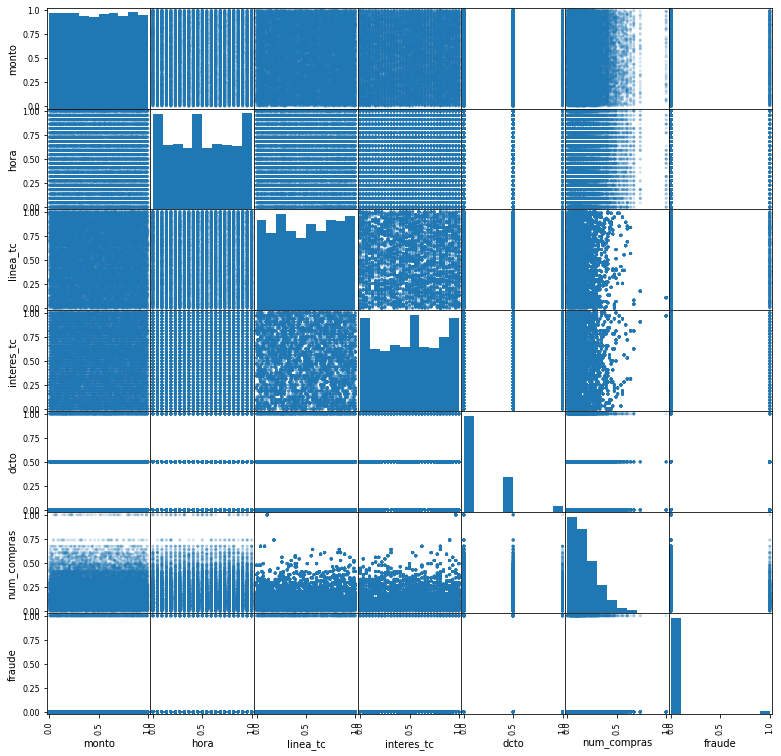

In [31]:
#Scatter plots
data_num.loc[:,['fraude']] = 1*data_num.fraude
scatter_matrix(data_num,alpha = 0.2,figsize = [13,13])


<font size= "3">Scatter plots do not show any clear non linear correlation. A little conclusion from the plots is that discounts are grouped in three defined regions: near zero, near 0.5 and near to 1.

# Categorization of Clients.

<font size="3"> In this section I classify the clients from the data using k-modes clustering algorithm as tool. Because is appropiate to use k-modes when all the data is categorical, I convert the numerical features in categorical. For this purpose each numerical column is divided in 3 equally spaced subintervals of the column range interval. Each entry in the column belong to the category given for a subinterval if this entry belong to the subinterval. 

In [32]:
# Numerical and categorical data with the modifications made before are unified.
data_f = data_categ.copy()
cols_num = list(data_num.columns)
data_f[cols_num] = data_num
data_f.fraude = data_categ.fraude
data_f.head()

,tipo_tc,status_txn,is_prime,device_score,os,fraude,monto,hora,linea_tc,interes_tc,dcto,num_compras
0,Física,Aceptada,False,3,ANDROID,False,0.608389,0.863636,0.621622,0.59375,0.5,0.016393
1,Virtual,Aceptada,False,1,ANDROID,False,0.088711,0.272727,0.621622,0.59375,0.0,0.016393
2,Virtual,En proceso,False,1,.,False,0.790099,0.454545,0.932432,0.75000,0.0,0.098361
3,Física,Aceptada,False,3,WEB,False,0.767064,0.454545,0.932432,0.75000,0.0,0.098361
4,Física,Aceptada,False,3,%%,False,0.254179,0.409091,0.932432,0.75000,0.0,0.098361


In [33]:
#data_f is saved
data_f.to_pickle('data_f.pkl')


In [34]:
# Clustering
#loading the preprocessed data
data = pd.read_pickle('data_f.pkl')

##data_uns: The data used for the categorization
data_uns = data.copy()

In [35]:
# Making bins to convert numerical data in categorical

cols_bin = cols_num[:-1]
for col in cols_bin:
    data_uns.loc[:,[col]] = pd.cut(data_uns[col],bins = 3).apply(lambda x:str(x))



In [36]:
data_uns.head()

,tipo_tc,status_txn,is_prime,device_score,os,fraude,monto,hora,linea_tc,interes_tc,dcto,num_compras
0,Física,Aceptada,False,3,ANDROID,False,"(0.333, 0.667]","(0.667, 1.0]","(0.333, 0.667]","(0.333, 0.667]","(0.333, 0.667]","(-0.001, 0.333]"
1,Virtual,Aceptada,False,1,ANDROID,False,"(-0.001, 0.333]","(-0.001, 0.333]","(0.333, 0.667]","(0.333, 0.667]","(-0.001, 0.333]","(-0.001, 0.333]"
2,Virtual,En proceso,False,1,.,False,"(0.667, 1.0]","(0.333, 0.667]","(0.667, 1.0]","(0.667, 1.0]","(-0.001, 0.333]","(-0.001, 0.333]"
3,Física,Aceptada,False,3,WEB,False,"(0.667, 1.0]","(0.333, 0.667]","(0.667, 1.0]","(0.667, 1.0]","(-0.001, 0.333]","(-0.001, 0.333]"
4,Física,Aceptada,False,3,%%,False,"(-0.001, 0.333]","(0.333, 0.667]","(0.667, 1.0]","(0.667, 1.0]","(-0.001, 0.333]","(-0.001, 0.333]"


<font size="3"> I apply k-modes for different number k of centroids. The goal is to choose a value k giving low cost, which ensures the quality of the found clusters. A criteria to choose k is the Elbow rule, as in the k-means algorithm. While the Elbow rule in k means ensures that the chosen k is the best possible k, in the case of k modes could exist many "elbows" along the "k vs cost" curve. This makes the choice more subjective. In any case, to choose a k from an elbow gives a guarantee of local stability along the cost values.

In [ ]:
cost = []
max_cl = 10
for num_clusters in list(range(1,max_cl)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(data_uns)
    cost.append(kmode.cost_)

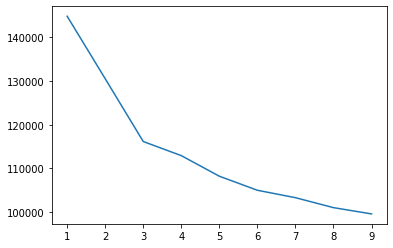

In [38]:
# In k = 6 the curve looks more stable than before
y = np.array([i for i in range(1,max_cl,1)])
plt.plot(y,cost)

<font size = "3"> The plot above has elbows in k = 3,4,5,6,7 and 8. The best k from the considered values is k = 5, because the curve after k = 5 has a significantly lesser derivative than the curve before. This suggests more local stability after k = 5.

The categorization of the clients that I consider is the given by the 5 clusters resulting of consider k modes with k = 5. I will plot frequency pictures for each one of the categories and for each one of the features, in order to explain some insights.

In [39]:
#k = 5 is reasonable choice
km = KModes(n_clusters=5, init='Cao', n_init=1, verbose=1)

clusters = km.fit_predict(data_uns)
centroids = km.cluster_centroids_


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5019, cost: 108204.0


In [40]:
# Making a df to visualize better the centroids
cent_df = pd.DataFrame(columns = list(data.columns))
for i in range(len(centroids)):
    cent_df.loc[i,:] = centroids[i]

cent_df

,tipo_tc,status_txn,is_prime,device_score,os,fraude,monto,hora,linea_tc,interes_tc,dcto,num_compras
0,Física,Aceptada,False,4,%%,False,"(-0.001, 0.333]","(-0.001, 0.333]","(0.667, 1.0]","(0.667, 1.0]","(-0.001, 0.333]","(-0.001, 0.333]"
1,Virtual,En proceso,False,2,WEB,False,"(0.333, 0.667]","(0.667, 1.0]","(-0.001, 0.333]","(0.333, 0.667]","(0.333, 0.667]","(-0.001, 0.333]"
2,Física,Aceptada,False,3,ANDROID,False,"(0.667, 1.0]","(0.333, 0.667]","(0.333, 0.667]","(-0.001, 0.333]","(0.333, 0.667]","(-0.001, 0.333]"
3,Física,Aceptada,False,5,.,False,"(0.667, 1.0]","(0.667, 1.0]","(-0.001, 0.333]","(0.333, 0.667]","(-0.001, 0.333]","(-0.001, 0.333]"
4,Física,Aceptada,False,1,WEB,False,"(0.333, 0.667]","(0.667, 1.0]","(0.333, 0.667]","(-0.001, 0.333]","(-0.001, 0.333]","(-0.001, 0.333]"


<font size = "3">Centroids can be thought as good representants of each cluster. The centroids above suggest that each cluster is represented for a unique device score. They also suggest that values of  "os" are a good discriminator between clusters, while categories in "num_compras" are not. This hyphotesis will be confirmed or neglected visualizing feature frequency plots for cluster below.


In [41]:
# Adding cluster information to data_uns
data_uns_comb = data_uns.copy().reset_index()
clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster']
data_clust = pd.concat([data_uns_comb, clustersDf], axis = 1).reset_index()
data_clust = data_clust.drop(['index', 'level_0'], axis = 1)


## Cluster 0

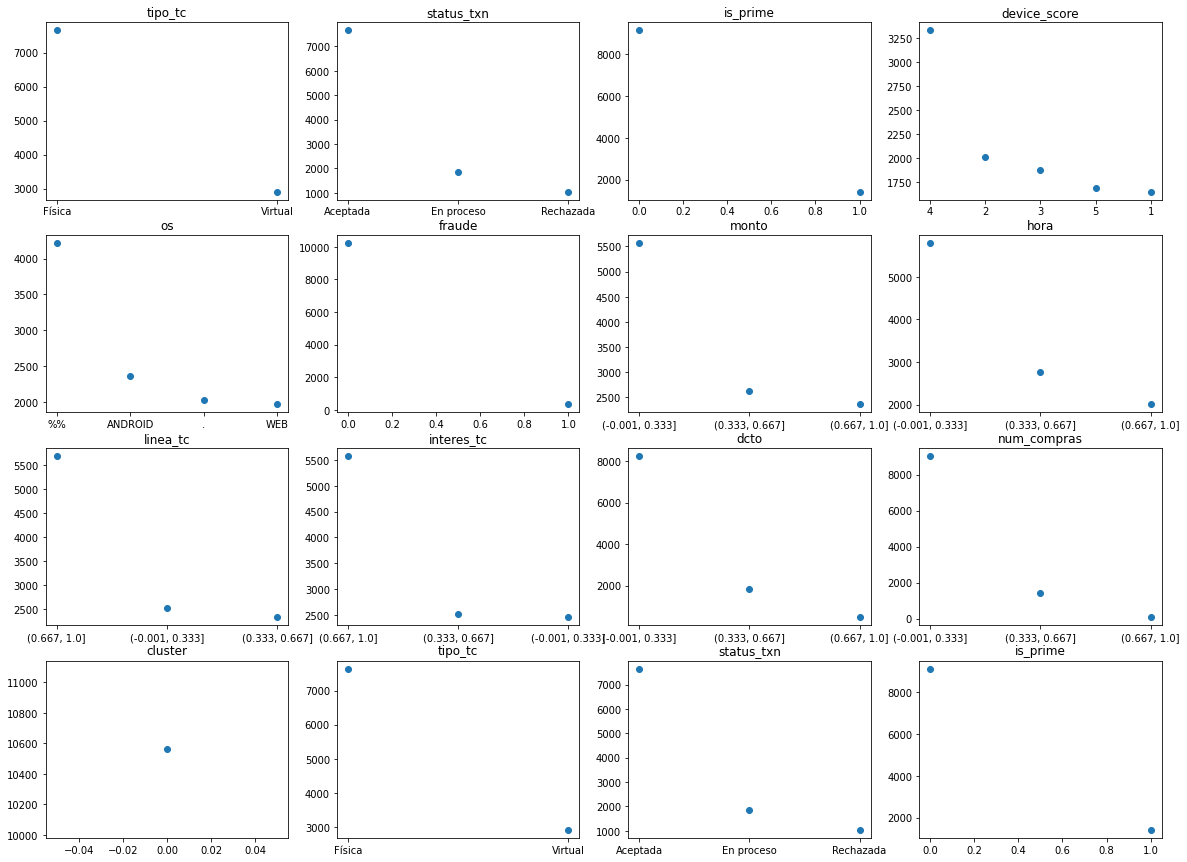

In [42]:
#Counting fraudsters for each group. 
clust_col = np.array(data_clust.columns)
clust_col = np.resize(clust_col,(4,4))
clust = data_clust[data_clust.cluster == 0]

fig, ax = plt.subplots(4,4,figsize=(20,15))
for i in range(4):
    for j in range(4):
        col = clust_col[i,j]
        cont = clust[col].value_counts()
        ind = list(cont.index)
        vals = cont.values
        ax[i,j].scatter(ind,vals)
        ax[i,j].set_title(f'{col}')

## Cluster 1

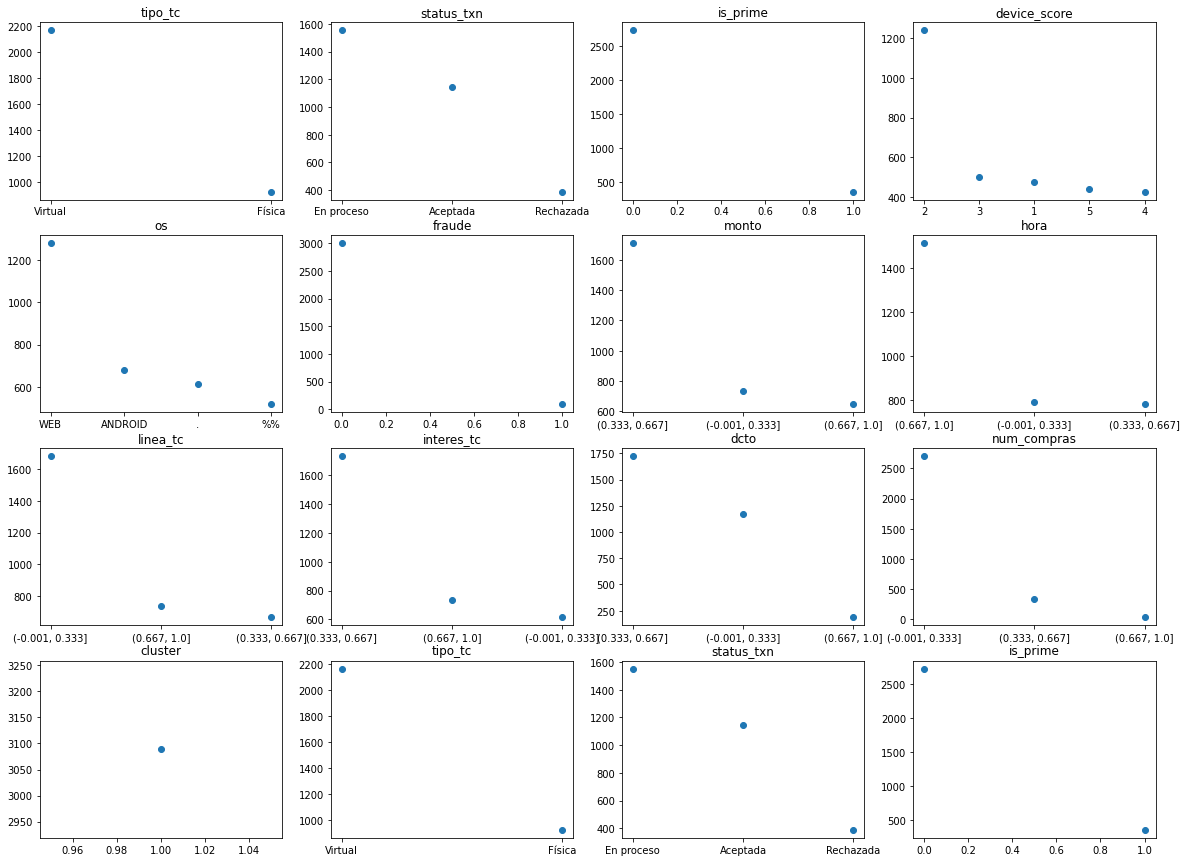

In [43]:
clust_0 = data_clust[data_clust.cluster == 1]

fig, ax = plt.subplots(4,4,figsize=(20,15))
for i in range(4):
    for j in range(4):
        col = clust_col[i,j]
        cont = clust_0[col].value_counts()
        ind = list(cont.index)
        vals = cont.values
        ax[i,j].scatter(ind,vals)
        ax[i,j].set_title(f'{col}')

## Cluster 2

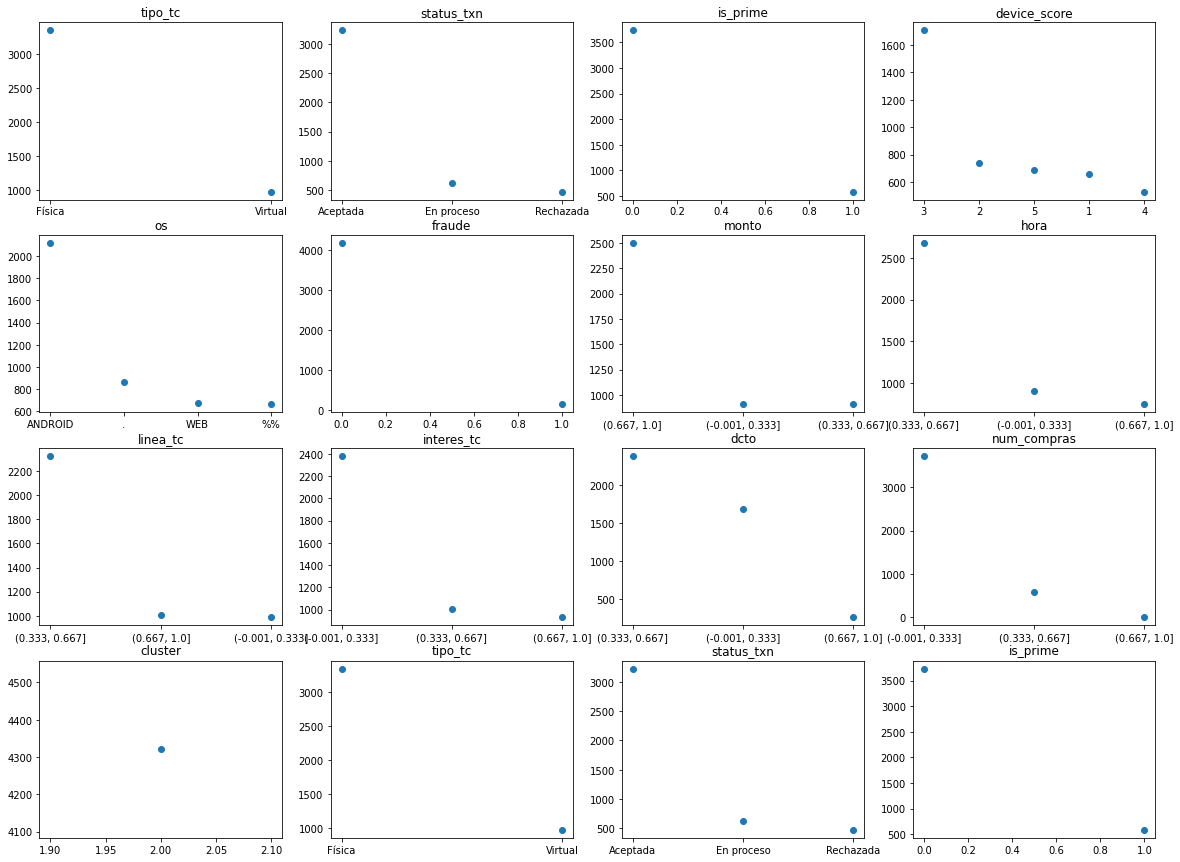

In [44]:
clust_0 = data_clust[data_clust.cluster == 2]

fig, ax = plt.subplots(4,4,figsize=(20,15))
for i in range(4):
    for j in range(4):
        col = clust_col[i,j]
        cont = clust_0[col].value_counts()
        ind = list(cont.index)
        vals = cont.values
        ax[i,j].scatter(ind,vals)
        ax[i,j].set_title(f'{col}')

## Cluster 3

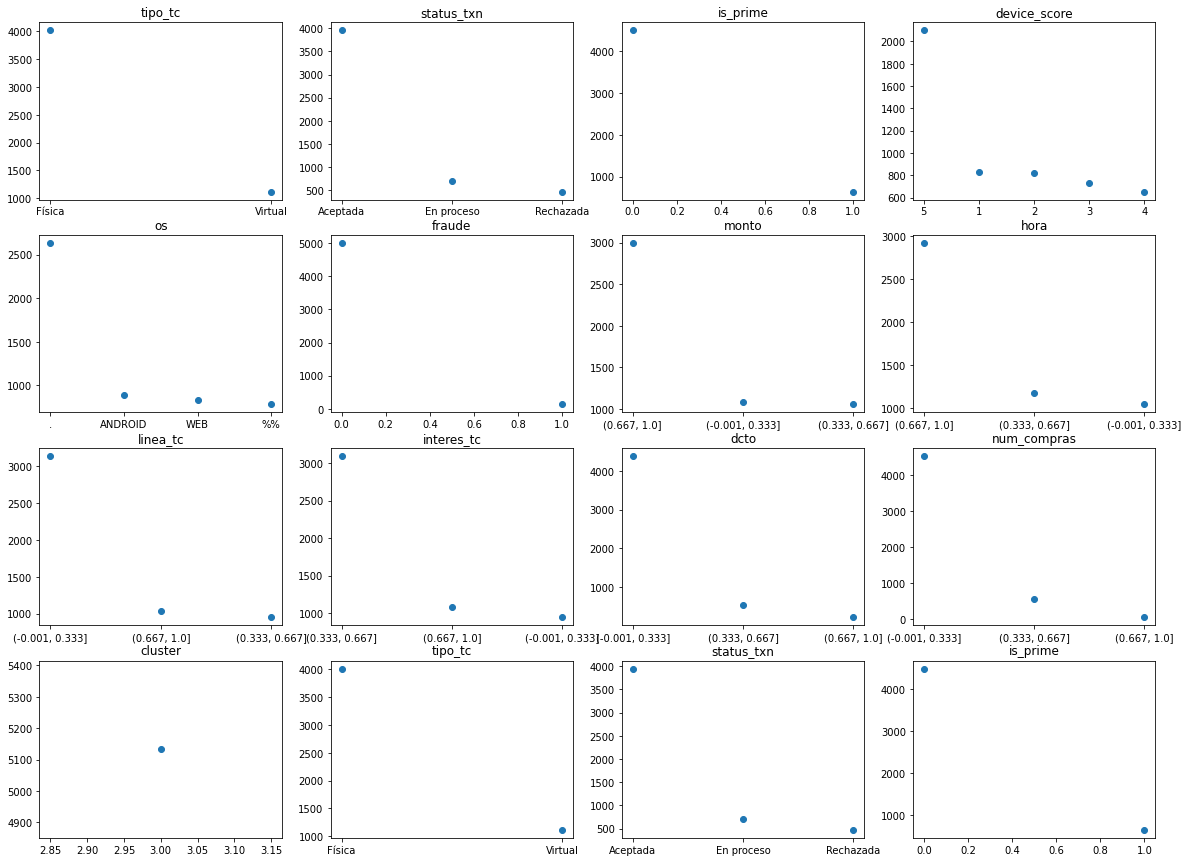

In [45]:
clust_0 = data_clust[data_clust.cluster == 3]

fig, ax = plt.subplots(4,4,figsize=(20,15))
for i in range(4):
    for j in range(4):
        col = clust_col[i,j]
        cont = clust_0[col].value_counts()
        ind = list(cont.index)
        vals = cont.values
        ax[i,j].scatter(ind,vals)
        ax[i,j].set_title(f'{col}')

## Cluster 4

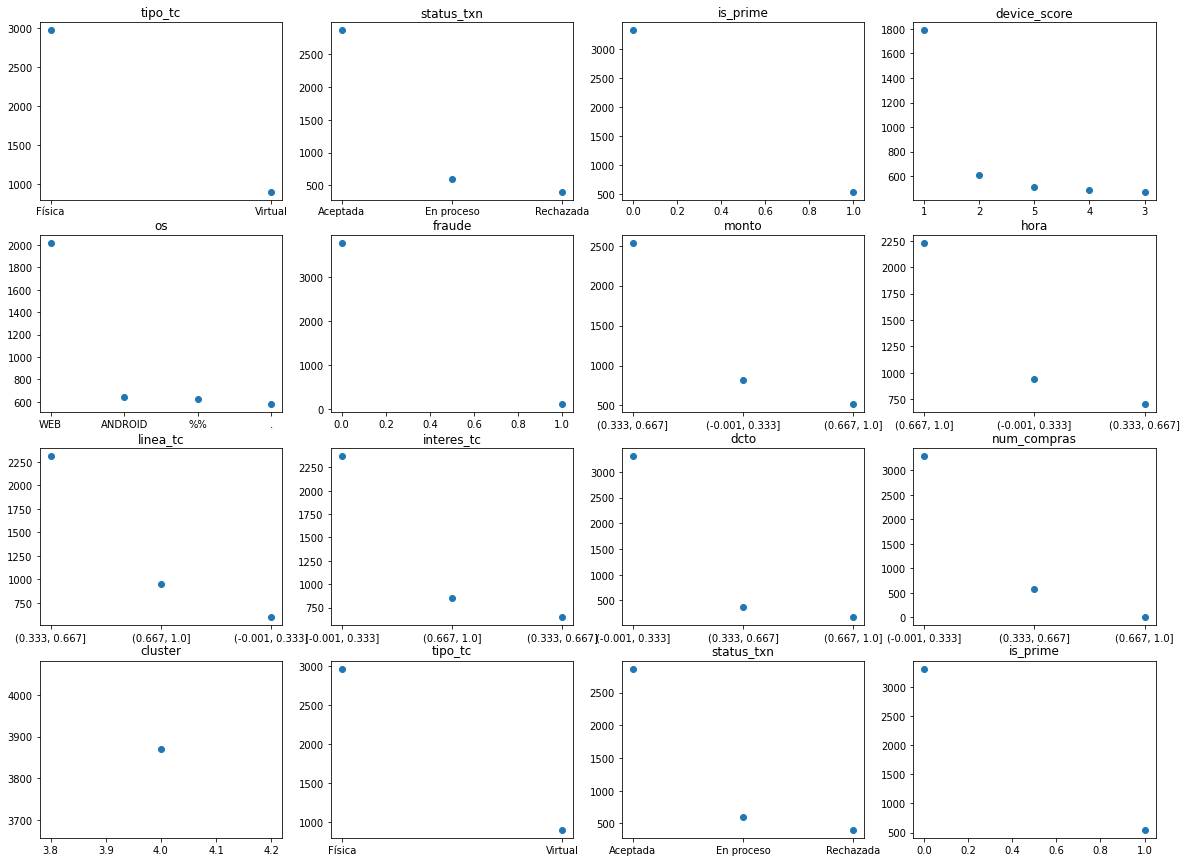

In [46]:
clust_0 = data_clust[data_clust.cluster == 4]

fig, ax = plt.subplots(4,4,figsize=(20,15))
for i in range(4):
    for j in range(4):
        col = clust_col[i,j]
        cont = clust_0[col].value_counts()
        ind = list(cont.index)
        vals = cont.values
        ax[i,j].scatter(ind,vals)
        ax[i,j].set_title(f'{col}')

<font size = "3"> From the plots, we can derive some conclusions:

- The "device_score" in each cluster has a unique highly dominant category, which is different between clusters. For example, in cluster 4, "3" is the dominant device score.

- In a given cluster, all the features have a highly dominant value, except "status_txn" in the Cluster 1, which has two values with high frequency.

- All the clusters has more or less the same number of prime users ("is_prime" near to 500) except the Cluster 0, with a high value in "is_prime"(near to 1500).

- Cluster 0 registers also the biggest number of big number of purchases (around 1700). This and the conclusion above suggest that this Cluster characterizes an important group clients for the business.

- The feature "os" subdivides the clusters in four groups: clusters 0,1 and 2 has their own and high frequency os. While, clusters 3 and 4 are described by the os "ANDROID", which is not representative in the another clusters.

This is just a little sample of conclusions that can be derived in order to describe clients in each cluster.

Now, and because the next task is to classify clients in fraudsters and non fraudsters, I will count the number of fraudsters for each cluster:

In [47]:
[f'Cluster {i}: '+ str(data_clust.fraude[data_clust.cluster == i].sum()) for i in range(5)]

['Cluster 0: 332',
 'Cluster 1: 90',
 'Cluster 2: 147',
 'Cluster 3: 133',
 'Cluster 4: 108']

<font size="3"> This exercise carries to an interesting conclusion: Cluster 0 at least doubles the number of fraudsters of the another clusters. It means that Cluster 0, which by the conclusions can be defined as the cluster of the "premium and more active" clients is also the cluster where frauds are more frequent.

The final comment before finish this section is that this clusters can be used as a first filter for our classification task.

# Classification

<font size= "3">In this section I use the Ridge classifier for the classification task. Two reasons motivated the choice. The first one, this is a modification of a linear regression, so is too interpretable. The second one is that some of the categorical variables report considerable correlation between them and this classifier deals well with the fact.

One of the main issues of our data is the remarkable low proportion of fraudsters. As shown in the preprocessing section, fraudters are just the 3% of the entire data. Trying to avoid this problem I resample to make less severe the imbalance of categories.

## Dividing and preparing the data.

<font size = "3"> First, I need to divide the data in trainning and test databases. This is done in the following cells. An important remark is that, given the imbalanced proportion of registers in the two categories to predict, it is important to ensure that both trainning and test databases contains the adecuate member proportion of both categories.

In [48]:
# Separating the categories vector from the features data.
X = data.loc[:,data.columns != 'fraude']
y = data.loc[:,'fraude']

In [49]:
# split into trainning and test sets, ensuring that both has enough
# proportion of fraudsters.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

<font size = "3"> By the nature of the Ridge classifier,it is necessary to convert the categorical variables to numerical. I use get_dummies method from Pandas for this purpose.

In [50]:
# Converting categorical data to numerical
categ_cols = ['tipo_tc','status_txn','is_prime','device_score','os']
X_train = pd.get_dummies(X_train,columns = categ_cols)
X_test = pd.get_dummies(X_test,columns = categ_cols)

In [51]:
#Categories: -1 for non fraudsters and 1 for fraudsters
y_train = y_train.apply(lambda x: (-1)**(1*x+1))
y_test = y_test.apply(lambda x: (-1)**(1*x+1))


<font size = "3"> Now the sampling and trainning can be done. I fix the trainning subset of fraudsters and sample on the trainning subset of non fraudsters.  The used proportion of non fraudsters will be the double of the fraudsters. In a cross validation process generating 10 samples I select the trained model with the f1_score. This score measure is appropiate for this situation, because measures the misclassification focused in the True Positives, which in our case is the sensible populalation: the correctly classified fraudsters. 

In [64]:
#fraud_ind: The indices for fraudsters
fraud_ind = (y_train==1).values
non_ind = (y_train==-1).values

numb_samp = 1000
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1])
clf_model = clf.fit(X_train, y_train.values.ravel())
y_hat = clf_model.predict(X_test)
score = f1_score(y_test.values.ravel(), y_hat)

X_fraud = X_train[fraud_ind]
N = 2*fraud_ind.sum()
for i in range(numb_samp):
    X_non = X_train[non_ind].sample(N)
    X_sam = pd.concat([X_non,X_fraud],axis = 0)

    yy = y_train[non_ind]
    y_sam = pd.concat([yy.iloc[0:N],y_train[fraud_ind]],axis = 0)
    
    clf_model2 = clf.fit(X_sam, y_sam.values.ravel())
    y_hat = clf_model2.predict(X_test)
    score2 = f1_score(y_test.values.ravel(), y_hat)
    if score2>=score:
        clf_model = clf_model2
        score = score2
    

In [66]:
y_hat = clf_model.predict(X_test)
score = f1_score(y_test.values.ravel(), y_hat)
score

0.0

<font size = "3"> The f1 score is reflecting the capability of the model to classify correctly the positive class. As high as better and in this case all models has a zero score. Recall that this values can change from one compilation to another, because the sampling process.

To illustrate how bad is the chosen model in a more empirical way, I calculate the number of True Positives identified by the model over the total number of True Positives. The algorithm can predict just less than 2% of the Positives.

In [68]:
y_pred = clf_model.predict(X_test)
(y_pred==1).sum()/(y_test==1).sum()

0.012345679012345678

<font size = "3">Now I will see the model coefficients, in order to identify what variables are the most important for the model.

In [69]:
#np.linalg.norm(y_pred - y_test.values.ravel())
clf_model.coef_
clf_model.intercept_
pd.DataFrame(clf_model.coef_[0],index = list(X_non.columns))



,0
monto,-0.105531
hora,0.086131
linea_tc,0.012931
interes_tc,-0.164687
dcto,0.031003
num_compras,0.314524
tipo_tc_Física,0.039668
tipo_tc_Virtual,-0.039668
status_txn_Aceptada,0.025845
status_txn_En proceso,0.055575


<font size = "3"> The most relevant variables for the model(identified for the higher absolute value in the coefficients) are "num_compras", "monto" and "hora". Variables "os"  and "device score" are the next more relevant ones, given the size of its category's coefficients, particularly "os_ANDROID" and "os_WEB" and in scores "1" and "4".

This can explain some of the low performance of the model. The two most relevant variables for the model are all numerical. As was seen in the sections of numerical and categorical data analysis, numerical data does not have a relevant correlation with the feature to predict. We have seen also that non linear dependency does not exist between numerical features and the feature to predict. For their part, categorical data has a relatively high correlation with the feature to predict and they are not so relevant for the model.

About the influence of the variables on the prediction, we can see that coefficients for "num_compras" and "hora" are positive. This implies that when the number of purchases is big is more possible that the user will be marked as fraudster. The same happens with "hora", when the purchase occurs late along the day, is more possible that will be marked as fraudster. On the other hand, beacause coefficient of "monto" is negative, it means that when "monto" is small is more possible to acquire the mark of fraudster. The same kind of interpretation based in the sign of coefficients follows for all the features.

Finally, while this model is highly interpretable and easy to train and evaluate, it is also very imprecise. Interpretability does not get to compensate the high inaccuracy of the model, which allows to confirm that this a bad model for the classification. 

<font size = "3"> The final task is to save the trained model for go to production:

In [70]:
with open('model.pkl', 'wb') as f:
  pickle.dump(clf, f)